In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
!pip install openpyxl
df = pd.read_excel('preprocessed_df.xlsx')

In [10]:
# df.drop(columns=['Unnamed: 0'],inplace=True)
# df.head()

In [11]:
df['age_group'] = pd.cut(df['age'], bins=[0,30,40,50,60,70,100])

(array([618., 529., 479., 660., 696., 788.]),
 array([  0.,  30.,  40.,  50.,  60.,  70., 100.]),
 <BarContainer object of 6 artists>)

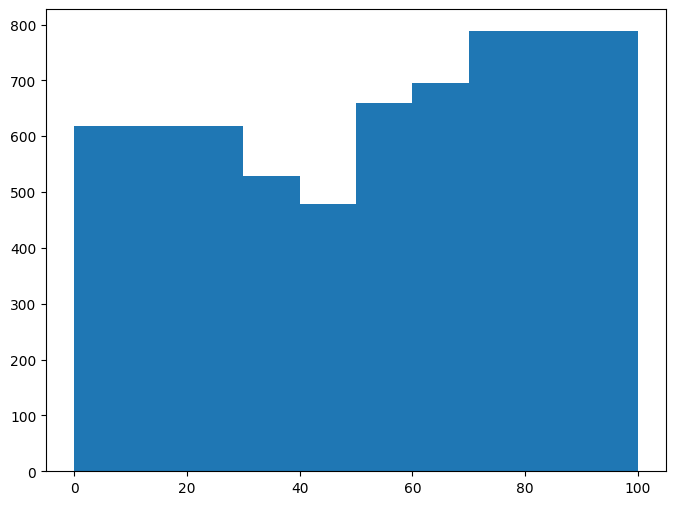

In [12]:
plt.figure(figsize=(8,6))
plt.hist(df['age'], bins = [0,30,40,50,60,70,100])

In [13]:
df['age_group']

0        (40, 50]
1         (0, 30]
2        (40, 50]
3        (60, 70]
4        (60, 70]
          ...    
3767      (0, 30]
3768     (60, 70]
3769    (70, 100]
3770    (70, 100]
3771     (60, 70]
Name: age_group, Length: 3772, dtype: category
Categories (6, interval[int64, right]): [(0, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 100]]

## Analysing missing ratios

In [24]:
columns=df.columns
for col in columns:
    df[col] = df[col].replace(-1, np.nan)

In [25]:
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,binaryClass,age_group
0,41.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1.30,2.5,125.0,1.14,109.0,1,"(40, 50]"
1,23.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,4.10,2.0,102.0,NaN,NaN,1,"(0, 30]"
2,46.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0.98,NaN,109.0,0.91,120.0,1,"(40, 50]"
3,70.0,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0.16,1.9,175.0,NaN,NaN,1,"(60, 70]"
4,70.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0.72,1.2,61.0,0.87,70.0,1,"(60, 70]"


In [26]:
missing_pct = (df.isnull().sum()/len(df)) * 100

In [27]:
missing_pct

age                           0.026511
sex                           3.976670
on thyroxine                  0.000000
query on thyroxine            0.000000
on antithyroid medication     0.000000
sick                          0.000000
pregnant                      0.000000
thyroid surgery               0.000000
I131 treatment                0.000000
query hypothyroid             0.000000
query hyperthyroid            0.000000
lithium                       0.000000
goitre                        0.000000
tumor                         0.000000
hypopituitary                 0.000000
psych                         0.000000
TSH                           9.782609
T3                           20.387063
TT4                           6.124072
T4U                          10.259809
FTI                          10.206787
binaryClass                   0.000000
age_group                     0.053022
dtype: float64

## Batch Conditioning

In [28]:
X = df.drop('binaryClass', axis = 1).copy()
y = df['binaryClass'].values

In [29]:
import numpy as np
import pandas as pd

# Assume your dataframe is called 'df' and target column is 'target' (0=benign, 1=malignant)
X = df.drop('binaryClass', axis=1).copy()
y = df['binaryClass'].values

# Replace any remaining '?' with NaN if still there
X = X.replace('?', np.nan)

# FIX: Handle categorical/object columns by mapping to numeric codes
for col in X.select_dtypes(include=['category', 'object']).columns:
    X[col] = pd.Categorical(X[col]).codes.astype(float)  # NaN becomes -1, strings to 0/1/etc.

X = X.astype(float)

def compute_conditioning(X, batch_size=2):
    n_samples, n_features = X.shape
    mini_conditions = []
    whole_conditions = []

    for col_idx in range(n_features):
        col = X.iloc[:, col_idx].values  # Now safe: numeric array
        
        # ---- Whole-batch conditioning (Algorithm 2) ----
        valid = ~np.isnan(col)
        if valid.sum() < 2:
            whole_cond = np.inf
        else:
            x_valid = np.abs(col[valid])
            ones = np.ones_like(x_valid)
            B_whole = np.column_stack([ones, x_valid])           
            try:
                BtB = B_whole.T @ B_whole
                eigenvalues = np.linalg.eigvals(BtB)
                eigenvalues = eigenvalues[np.abs(eigenvalues) > 1e-10]  # Filter near-zero
                if len(eigenvalues) < 2:
                    cond_whole = np.inf
                else:
                    cond_whole = np.max(np.abs(eigenvalues)) / np.min(np.abs(eigenvalues))
            except:
                cond_whole = np.inf
        whole_conditions.append(cond_whole)

        # ---- Mini-batch conditioning (Algorithm 1) ----
        conds_mini = []
        i = 0
        while i + batch_size <= n_samples:
            batch = col[i:i+batch_size]
            nan_mask = ~np.isnan(batch)
            if np.sum(nan_mask) < 2:  # Need at least 2 valid points
                i += batch_size
                continue
            x_batch = np.abs(batch[nan_mask])
            ones = np.ones_like(x_batch)
            B = np.column_stack([ones, x_batch])
            try:
                BtB = B.T @ B
                eigenvalues = np.linalg.eigvals(BtB)
                eigenvalues = eigenvalues[np.abs(eigenvalues) > 1e-10]
                if len(eigenvalues) < 2:
                    cond = np.inf
                else:
                    cond = np.max(np.abs(eigenvalues)) / np.min(np.abs(eigenvalues))
                conds_mini.append(cond)
            except:
                conds_mini.append(np.inf)
            i += batch_size
        
        mini_conditions.append(np.mean(conds_mini) if conds_mini else np.inf)

    return np.array(mini_conditions), np.array(whole_conditions)

# Run it
mini_cond, whole_cond = compute_conditioning(X, batch_size=2)

# Show results like the paper (Figures 5 & 6)
result = pd.DataFrame({
    'Feature': X.columns,
    'Missing %': (X.isnull().sum() / len(X) * 100).round(3),
    'Mini-batch Condition': np.log10(np.maximum(mini_cond, 1)).round(2),  # Log10 for readability like paper
    'Whole-batch Condition': np.log10(np.maximum(whole_cond, 1)).round(2)
}).sort_values('Mini-batch Condition', ascending=False)

print(result)

                                             Feature  Missing %  \
age                                              age      0.027   
sex                                              sex      3.977   
FTI                                              FTI     10.207   
T4U                                              T4U     10.260   
TT4                                              TT4      6.124   
T3                                                T3     20.387   
TSH                                              TSH      9.783   
psych                                          psych      0.000   
hypopituitary                          hypopituitary      0.000   
tumor                                          tumor      0.000   
goitre                                        goitre      0.000   
lithium                                      lithium      0.000   
query hyperthyroid                query hyperthyroid      0.000   
query hypothyroid                  query hypothyroid      0.00

## Dimensionality reduction

In [30]:
#Target correlation
target_corr = X.corrwith(pd.Series(y, name='target')).abs().sort_values(ascending=False)

#Inner similarity
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [col for col in upper.columns if any(upper[col]>0.85)]

X_reduced = X.drop(high_corr_pairs, axis=1)

#keeping only top 12-15 most target-informative features
selected_features = target_corr.drop(high_corr_pairs, errors='ignore').head(15).index
X_reduced = X_reduced[selected_features]

print("Reduced from", X.shape[1], "->", X_reduced.shape[1],"features")
print(selected_features.tolist())


Reduced from 22 -> 15 features
['TSH', 'FTI', 'TT4', 'T3', 'query hypothyroid', 'on thyroxine', 'sex', 'pregnant', 'T4U', 'psych', 'goitre', 'on antithyroid medication', 'thyroid surgery', 'query hyperthyroid', 'query on thyroxine']


In [31]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

Z = linkage(X_reduced.fillna(X_reduced.median()), 'ward')
clusters = fcluster(Z, t=150, criterion='maxclust')   # adjust 150 → 200–400 samples

X_final = X_reduced.groupby(clusters).mean()
y_final = pd.Series(y).groupby(clusters).first()

print("Reduced from", len(y), "→", len(y_final), "samples")

Reduced from 3772 → 150 samples


In [32]:
X_final['label'] = y_final

In [33]:
X_final.to_excel('merged_df.xlsx', index=False)

In [37]:
X_final

,TSH,FTI,TT4,T3,query hypothyroid,on thyroxine,sex,pregnant,T4U,psych,goitre,on antithyroid medication,thyroid surgery,query hyperthyroid,query on thyroxine,label
1,1.895000,95.300000,158.200000,3.955556,0.100000,0.000000,0.000000,0.200000,1.662000,0.000000,0.0,0.000000,0.000000,0.300000,0.000000,1
2,2.795882,102.923077,166.666667,2.994118,0.000000,0.277778,0.166667,0.166667,1.606923,0.055556,0.0,0.055556,0.000000,0.055556,0.055556,1
3,1.436667,127.714286,178.714286,2.700000,0.142857,0.571429,0.000000,0.000000,1.400000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
4,1.533636,118.000000,169.500000,2.790000,0.000000,0.333333,0.100000,0.166667,1.439167,0.000000,0.0,0.000000,0.000000,0.083333,0.000000,1
5,1.192619,125.761905,150.047619,2.360000,0.047619,0.142857,0.238095,0.000000,1.193333,0.238095,0.0,0.000000,0.047619,0.047619,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,41.000000,27.400000,27.600000,0.840000,0.000000,0.000000,0.600000,0.000000,1.048000,0.000000,0.0,0.000000,0.200000,0.200000,0.000000,0
147,55.666667,9.800000,10.188889,0.450000,0.000000,0.111111,0.222222,0.000000,1.033333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
148,102.857143,9.714286,10.257143,0.400000,0.000000,0.000000,0.571429,0.000000,1.048571,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0
149,66.333333,22.333333,25.000000,1.200000,0.000000,0.000000,0.000000,0.000000,1.110000,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,1


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
y = X_final['label']                  
X = X_final.drop(columns=['label'])


print(f"Total prototypes       : {len(y)}")
print(f"Number of features     : {X.shape[1]}")
print(f"Class distribution before split:\n{y.value_counts()}\n")


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size     = 0.25,      # 75% train, 25% test
    random_state  = 42,
    stratify      = y,         # keeps same class ratio
    shuffle       = True
)

print("=== FINAL SPLIT ===")
print(f"Train samples  → {len(y_train)}")
print(f"Test samples   → {len(y_test)}")

X_train = X_train.values
X_test  = X_test.values
y_train = y_train.values
y_test  = y_test.values


Total prototypes       : 150
Number of features     : 15
Class distribution before split:
label
1    118
0     32
Name: count, dtype: int64

=== FINAL SPLIT ===
Train samples  → 112
Test samples   → 38
Train class ratio:
label
1    0.786
0    0.214
Name: proportion, dtype: float64
Test class ratio :
label
1    0.789
0    0.211
Name: proportion, dtype: float64


Predicted scores (first 20): [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
Min: nan Max: nan
Test accuracy: 21.05%


In [270]:
import numpy as np

# bLS
#leaving all the rows with missing values
print("Original train samples:", len(X_train))
train_mask = np.isfinite(X_train).all(axis=1)   
test_mask  = np.isfinite(X_test).all(axis=1)

X_train_comp = X_train[train_mask]
y_train_comp = y_train[train_mask]

X_test_comp = X_test[test_mask]
y_test_comp = y_test[test_mask]

print(f" Dropped all missing rows Train: {len(X_train_comp)}, Test: {len(X_test_comp)}")

y_train_comp = y_train_comp.astype(float)
y_test_comp  = y_test_comp.astype(float)


b_train = np.hstack([np.ones((X_train_comp.shape[0], 1)), X_train_comp])
b_test  = np.hstack([np.ones((X_test_comp.shape[0],  1)), X_test_comp])

# Batch Least Squares — Equation (21) 
w = np.linalg.inv(b_train.T @ b_train) @ (b_train.T @ y_train_comp)
y_pred = b_test @ w

y_pred_class = (y_pred >= 0.5).astype(int)


train_acc = np.mean((b_train @ w >= 0.5).astype(int) == y_train_comp) * 100
test_acc  = np.mean(y_pred_class == y_test_comp) * 100


print(f"Train samples used: {len(y_train_comp)}")
print(f"Test samples used : {len(y_test_comp)}")
print(f"Train accuracy    : {train_acc:.2f}%")
print(f"Test accuracy     : {test_acc:.2f}%")


from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, F1 for test set
precision = precision_score(y_test_comp, y_pred_test_class)
recall = recall_score(y_test_comp, y_pred_test_class)
f1 = f1_score(y_test_comp, y_pred_test_class)

print(f"Precision (Test) : {precision:.2f}")
print(f"Recall (Test)    : {recall:.2f}")
print(f"F1-score (Test)  : {f1:.2f}")

# Optional: also compute for training set
precision_train = precision_score(y_train_comp, y_pred_train_class)
recall_train = recall_score(y_train_comp, y_pred_train_class)
f1_train = f1_score(y_train_comp, y_pred_train_class)

print(f"Precision (Train) : {precision_train:.2f}")
print(f"Recall (Train)    : {recall_train:.2f}")
print(f"F1-score (Train)  : {f1_train:.2f}")




Original train samples: 120
 Dropped all missing rows Train: 115, Test: 27
Train samples used: 115
Test samples used : 27
Train accuracy    : 93.04%
Test accuracy     : 85.19%
Precision (Test) : 0.81
Recall (Test)    : 1.00
F1-score (Test)  : 0.89
Precision (Train) : 0.87
Recall (Train)    : 0.95
F1-score (Train)  : 0.91


In [279]:

#INN algorithm

eta = 0.01  # value of eta is noy given in paper assuming 0.01
w = np.zeros(b_train.shape[1]) 

# Single pass no batches and epochs
for k in range(b_train.shape[0]):
    b_k = b_train[k]
    y_k = y_train_comp[k]
    y_hat = np.dot(b_k, w)  
    e_k = y_k - y_hat      
    w = w + eta * e_k * b_k 

# Prediction
y_pred = b_test @ w
y_pred_class = (y_pred >= 0.5).astype(int)
train_pred = (b_train @ w >= 0.5).astype(int)
train_acc = np.mean(train_pred == y_train_comp) * 100
test_acc = np.mean(y_pred_class == y_test_comp) * 100

print(f"Train samples used: {len(y_train_comp)}")
print(f"Test samples used : {len(y_test_comp)}")
print(f"Train accuracy : {train_acc:.2f}%")
print(f"Test accuracy : {test_acc:.2f}%")


from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, F1 for test set
precision = precision_score(y_test_comp, y_pred_test_class)
recall = recall_score(y_test_comp, y_pred_test_class)
f1 = f1_score(y_test_comp, y_pred_test_class)

print(f"Precision (Test) : {precision:.2f}")
print(f"Recall (Test)    : {recall:.2f}")
print(f"F1-score (Test)  : {f1:.2f}")

# Optional: also compute for training set
precision_train = precision_score(y_train_comp, y_pred_train_class)
recall_train = recall_score(y_train_comp, y_pred_train_class)
f1_train = f1_score(y_train_comp, y_pred_train_class)

print(f"Precision (Train) : {precision_train:.2f}")
print(f"Recall (Train)    : {recall_train:.2f}")
print(f"F1-score (Train)  : {f1_train:.2f}")


Train samples used: 115
Test samples used : 27
Train accuracy : 81.74%
Test accuracy : 77.78%
Precision (Test) : 0.81
Recall (Test)    : 1.00
F1-score (Test)  : 0.89
Precision (Train) : 0.87
Recall (Train)    : 0.95
F1-score (Train)  : 0.91


In [280]:
import numpy as np
#LSLC without shuffling
#same processing as above



X_mean = X_train_comp.mean(axis=0)
X_std  = X_train_comp.std(axis=0) + 1e-8  # avoid div by zero

X_train_norm = (X_train_comp - X_mean) / X_std
X_test_norm  = (X_test_comp - X_mean) / X_std

b_train = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])
b_test  = np.hstack([np.ones((X_test_norm.shape[0], 1)), X_test_norm])


# 3. LSLC parameters 

eta     = 0.5     
alpha   = -1.0    
p_alpha = 1.0     
eta_c   = 0.1   
epochs  = 10   

# Initialize weights
w = np.zeros(b_train.shape[1])


for epoch in range(epochs):
    for k in range(len(b_train)):
        b_k = b_train[k]
        y_k = y_train_comp[k]

        # Predicted output
        y_hat = np.dot(b_k, w)
        e_k = y_k - y_hat

        # Unconstrained update (like INN)
        w_unconst = w + eta * e_k * b_k

        # Projected update to enforce bounds
        w_proj = np.clip(w_unconst, alpha, p_alpha)

        # Constrained incremental step
        w = w + eta_c * (w_proj - w)
      # Monitor convergence
    y_train_pred = b_train @ w
    mse_train = np.mean((y_train_pred - y_train_comp)**2)
    train_acc_epoch = np.mean((y_train_pred >= 0.5).astype(int) == y_train_comp) * 100
    
    if (epoch + 1) % 2 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:2d}: MSE={mse_train:.6f}, Train Acc={train_acc_epoch:.2f}%")
   


y_pred_train = b_train @ w
y_pred_test  = b_test  @ w

y_pred_train_class = (y_pred_train >= 0.5).astype(int)
y_pred_test_class  = (y_pred_test  >= 0.5).astype(int)

train_acc = np.mean(y_pred_train_class == y_train_comp) * 100
test_acc  = np.mean(y_pred_test_class  == y_test_comp)  * 100


print("LSLC — Least Squares Linear Classifier (Incremental, Constrained)")
print(f"Parameters: η={eta}, α={alpha}, pα={p_alpha}, η^c={eta_c}, epochs={epochs}")
print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy : {test_acc:.2f}%")

from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, F1 for test set
precision = precision_score(y_test_comp, y_pred_test_class)
recall = recall_score(y_test_comp, y_pred_test_class)
f1 = f1_score(y_test_comp, y_pred_test_class)

print(f"Precision (Test) : {precision:.2f}")
print(f"Recall (Test)    : {recall:.2f}")
print(f"F1-score (Test)  : {f1:.2f}")

# Optional: also compute for training set
precision_train = precision_score(y_train_comp, y_pred_train_class)
recall_train = recall_score(y_train_comp, y_pred_train_class)
f1_train = f1_score(y_train_comp, y_pred_train_class)

print(f"Precision (Train) : {precision_train:.2f}")
print(f"Recall (Train)    : {recall_train:.2f}")
print(f"F1-score (Train)  : {f1_train:.2f}")




  Epoch  1: MSE=0.124874, Train Acc=85.22%
  Epoch  2: MSE=0.120314, Train Acc=85.22%
  Epoch  4: MSE=0.119443, Train Acc=85.22%
  Epoch  6: MSE=0.120205, Train Acc=85.22%
  Epoch  8: MSE=0.120985, Train Acc=84.35%
  Epoch 10: MSE=0.121465, Train Acc=84.35%
LSLC — Least Squares Linear Classifier (Incremental, Constrained)
Parameters: η=0.5, α=-1.0, pα=1.0, η^c=0.1, epochs=10
Train Accuracy: 84.35%
Test Accuracy : 81.48%
Precision (Test) : 0.81
Recall (Test)    : 1.00
F1-score (Test)  : 0.89
Precision (Train) : 0.87
Recall (Train)    : 0.95
F1-score (Train)  : 0.91


In [282]:
#same processing as above  LSLS with shuffled data 


# 3. LSLC parameters 

eta     = 0.5     
alpha   = -1.0    
p_alpha = 1.0     
eta_c   = 0.1      
epochs  = 5    

# Initialize weights
w = np.zeros(b_train.shape[1])
for epoch in range(epochs):
    # Shuffle data each epoch
    indices = np.random.permutation(len(b_train))
    
    for idx in indices:
        b_k = b_train[idx]
        y_k = y_train_comp[idx]
        
        # Predicted output
        y_hat = np.dot(b_k, w)
        e_k = y_k - y_hat
        
        # Unconstrained update
        w_unconst = w + eta * e_k * b_k
        
        # Projected update to enforce bounds
        w_proj = np.clip(w_unconst, alpha, p_alpha)
        
        # Constrained incremental step
        w = w + eta_c * (w_proj - w)
    
    # Monitor convergence
    y_train_pred = b_train @ w
    mse_train = np.mean((y_train_pred - y_train_comp)**2)
    train_acc_epoch = np.mean((y_train_pred >= 0.5).astype(int) == y_train_comp) * 100
    
    if (epoch + 1) % 2 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:2d}: MSE={mse_train:.6f}, Train Acc={train_acc_epoch:.2f}%")

y_pred_train = b_train @ w
y_pred_test  = b_test  @ w
y_pred_train_class = (y_pred_train >= 0.5).astype(int)
y_pred_test_class  = (y_pred_test  >= 0.5).astype(int)

train_acc = np.mean(y_pred_train_class == y_train_comp) * 100
test_acc  = np.mean(y_pred_test_class  == y_test_comp)  * 100


print(f"Parameters: η={eta}, α={alpha}, p_α={p_alpha}, η^c={eta_c}, epochs={epochs}")
print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy : {test_acc:.2f}%")

from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, F1 for test set
precision = precision_score(y_test_comp, y_pred_test_class)
recall = recall_score(y_test_comp, y_pred_test_class)
f1 = f1_score(y_test_comp, y_pred_test_class)

print(f"Precision (Test) : {precision:.2f}")
print(f"Recall (Test)    : {recall:.2f}")
print(f"F1-score (Test)  : {f1:.2f}")

# Optional: also compute for training set
precision_train = precision_score(y_train_comp, y_pred_train_class)
recall_train = recall_score(y_train_comp, y_pred_train_class)
f1_train = f1_score(y_train_comp, y_pred_train_class)

print(f"Precision (Train) : {precision_train:.2f}")
print(f"Recall (Train)    : {recall_train:.2f}")
print(f"F1-score (Train)  : {f1_train:.2f}")



  Epoch  1: MSE=0.154665, Train Acc=92.17%
  Epoch  2: MSE=0.119620, Train Acc=83.48%
  Epoch  4: MSE=0.148611, Train Acc=86.96%
Parameters: η=0.5, α=-1.0, p_α=1.0, η^c=0.1, epochs=5
Train Accuracy: 93.91%
Test Accuracy : 81.48%
Precision (Test) : 0.81
Recall (Test)    : 1.00
F1-score (Test)  : 0.89
Precision (Train) : 0.94
Recall (Train)    : 0.99
F1-score (Train)  : 0.96


In [267]:
import numpy as np


# ICA for linear classification

# ICA hyperparameters 
num_countries = 1000 # population size
num_imperialists = 5  # top countries acting as imperialists
max_iters = 50        # maximum iterations
revolution_rate = 0.1 # probability of random mutation

num_weights = b_train.shape[1]

# Initialize countries (weight vectors)
countries = np.random.uniform(-1, 1, size=(num_countries, num_weights))

# Fitness function: mean squared error
def fitness(w, X, y):
    y_pred = X @ w
    return np.mean((y - y_pred)**2)

# ICA main loop
for iteration in range(max_iters):
    # Evaluate fitness for all countries
    fit_vals = np.array([fitness(c, b_train, y_train_comp) for c in countries])
    
    # Rank countries (lower MSE is better)
    sorted_idx = np.argsort(fit_vals)
    countries = countries[sorted_idx]
    
    imperialists = countries[:num_imperialists]
    colonies = countries[num_imperialists:]
    
    # Assimilation: move colonies slightly towards imperialists
    for i in range(len(colonies)):
        imp_idx = i % num_imperialists
        colonies[i] += 0.1 * (imperialists[imp_idx] - colonies[i])
    
    # Revolution: random mutation
    for i in range(len(colonies)):
        if np.random.rand() < revolution_rate:
            colonies[i] = np.random.uniform(-1, 1, size=num_weights)
    
    # Combine back imperialists + colonies
    countries = np.vstack([imperialists, colonies])

# Pick best country as final weights
w_ica = countries[0]

y_pred_train = b_train @ w_ica
y_pred_test  = b_test  @ w_ica

y_pred_train_class = (y_pred_train >= 0.5).astype(int)
y_pred_test_class  = (y_pred_test  >= 0.5).astype(int)

train_acc = np.mean(y_pred_train_class == y_train_comp) * 100
test_acc  = np.mean(y_pred_test_class == y_test_comp) * 100

print(f"ICA Train accuracy: {train_acc:.2f}%")
print(f"ICA Test  accuracy: {test_acc:.2f}%")




ICA Train accuracy: 93.91%
ICA Test  accuracy: 85.19%
